In [12]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
mpl.rcParams['figure.figsize'] = (20.0, 16.0)
import numpy as np
import cv2
import os

In [2]:
device = torch.device("cuda:0")

In [3]:
class encoder(nn.Module):
    
    def __init__(self):
        super(encoder, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, 5, stride=2, padding=2)
        self.conv2 = nn.Conv2d(16, 64, 5, stride=2, padding=2)
        self.conv3 = nn.Conv2d(64, 128, 5, stride=4, padding=2)
       
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        
        return x        

In [4]:
class decoder(nn.Module):
   
    def __init__(self):
        super(decoder, self).__init__()
            
        self.deconv4 = nn.ConvTranspose2d(256, 64, 4, stride=4)
        self.deconv5 = nn.ConvTranspose2d(64, 16, 4, stride=4)
        self.conv6 = nn.Conv2d(16, 1, 5, padding=2)        
  
    def forward(self, x):
        x = F.relu(self.deconv4(x))
        x = F.relu(self.deconv5(x))
        x = F.tanh(self.conv6(x))
        x = (x+1)/2
        return x 

In [5]:
class mfnet(nn.Module):
    
    def __init__(self):
        super(mfnet, self).__init__()
        
        self._encoder = encoder()
        self._decoder = decoder()
        
    def forward(self, X1, X2, rtrn_feature = False):
        x1 = self._encoder(X1)
        x2 = self._encoder(X2)
        x = torch.cat((x1, x2), 1)
        x = self._decoder(x)
        if rtrn_feature:
            return x
        x = x.repeat(1, 3, 1, 1)
        x = x * X1 + (1 - x) * X2
        return x

In [6]:
net = mfnet().to(device)
print(net)

mfnet(
  (_encoder): encoder(
    (conv1): Conv2d(3, 16, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
    (conv2): Conv2d(16, 64, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
    (conv3): Conv2d(64, 128, kernel_size=(5, 5), stride=(4, 4), padding=(2, 2))
  )
  (_decoder): decoder(
    (deconv4): ConvTranspose2d(256, 64, kernel_size=(4, 4), stride=(4, 4))
    (deconv5): ConvTranspose2d(64, 16, kernel_size=(4, 4), stride=(4, 4))
    (conv6): Conv2d(16, 1, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  )
)


In [7]:
criterion = nn.MSELoss()
optimizer = optim.Adam(net.parameters(), lr = 0.001)

In [8]:
def readImg(path):
    
    I = cv2.imread(path)
    I = cv2.cvtColor(I, cv2.COLOR_BGR2RGB)
    I = np.transpose(I, (-1, 0, 1))/127.5-1
    
    return I

def dataloader(path, batch_size = 32, isTest = False):
    X1, X2, y = [], [], []
    random_list = np.random.randint(1, 3201, size=batch_size)
    if isTest:
        random_list = np.arange(3201, 4001)
    for i in random_list:
        try:
            xx1 = readImg(os.path.join(path, "{:04d}_1.jpeg".format(i)))
            xx2 = readImg(os.path.join(path, "{:04d}_2.jpeg".format(i)))
            yy = readImg(os.path.join(path, "{:04d}_0.jpeg".format(i)))
        except:
            print("errneous idx: ", i)
        y.append(torch.Tensor(yy))
        X1.append(torch.Tensor(xx1))
        X2.append(torch.Tensor(xx2))
    X1 = torch.stack(X1)
    X2 = torch.stack(X2)
    y = torch.stack(y)
    return (X1, X2), y

In [9]:
for epoch in range(1000):
    loss = 0.0
    optimizer.zero_grad()
    
    (X1, X2), y = dataloader('../datasets/testcase_pro/')
    y_pred = net(X1.to(device), X2.to(device))
    
    loss = criterion(y_pred, y.to(device))
    loss.backward()
    optimizer.step()

    loss += loss.item()
    
    if epoch % 20 == 19:
        print("loss: {:.6f}".format(loss.item()/20))
        loss = 0.0

/home/kyle/anaconda3/envs/pytorch/lib/python3.6/site-packages/torch/nn/functional.py:1374: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


loss: 0.001129
loss: 0.000592
loss: 0.000670
loss: 0.000478
loss: 0.000608
loss: 0.000724
loss: 0.000595
loss: 0.000502
loss: 0.000312
loss: 0.000540
loss: 0.000623
loss: 0.000559
loss: 0.000513
loss: 0.000537
loss: 0.000378
loss: 0.000515
loss: 0.000478
loss: 0.000586
loss: 0.000406
loss: 0.000308
loss: 0.000560
loss: 0.000406
loss: 0.000512
loss: 0.000430
loss: 0.000415
loss: 0.000545
loss: 0.000345
loss: 0.000379
loss: 0.000390
loss: 0.000493
loss: 0.000441
loss: 0.000365
loss: 0.000350
loss: 0.000367
loss: 0.000404
loss: 0.000553
loss: 0.000448
loss: 0.000427
loss: 0.000414
loss: 0.000397
loss: 0.000400
loss: 0.000430
loss: 0.000381
loss: 0.000456
loss: 0.000393
loss: 0.000663
loss: 0.000431
loss: 0.000482
loss: 0.000478
loss: 0.000483


In [10]:
with torch.no_grad():
    (X1, X2), y = dataloader('../datasets/testcase_pro/', isTest = True)
    y_pred = net(X1.to(device), X2.to(device))
    y_features = net(X1.to(device), X2.to(device), rtrn_feature = True)
    
y_prediction = y_pred.cpu().numpy()
y_prediction = np.transpose(y_prediction, (0, 2, 3, 1))
y_f = y_features.cpu().numpy()
y_f = np.transpose(y_f, (0, 2, 3, 1))
y = np.transpose(y, (0, 2, 3, 1))
X1 = np.transpose(X1, (0, 2, 3, 1))
X2 = np.transpose(X2, (0, 2, 3, 1))

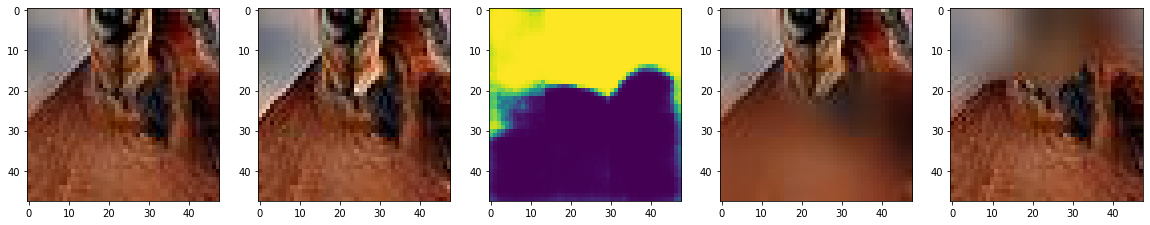

In [13]:
idx = 20
fig, ax = plt.subplots(1, 5)
ax[0].imshow(y_prediction[idx]/2+0.5)
ax[1].imshow(y[idx]/2+0.5)
ax[2].imshow(y_f[idx, :, :, 0])
ax[3].imshow(X1[idx]/2+0.5)
ax[4].imshow(X2[idx]/2+0.5)